# Exemple 1 : running a simple yield simulation for one year - Niger millet 2017

The purpose of this notebook is to demonstrate how to use the SARRA-Py package to prepare input data and perform attainable yield simulations for millet in Niger. This example focuses on a single year (2017) to provide a step-by-step guide for users who wish to apply SARRA-Py in similar agroclimatic analyses.

Niger, a large country in the Sahel region, presents computational challenges due to its extensive geographical coverage and data volume. If your computer has limited RAM (e.g., less than 16 GB), you may encounter crashes during computations. To address this issue on Unix-based systems, you can increase your SWAP file size, which serves as virtual memory when physical RAM is insufficient. Below are the commands to create a 12 GB SWAP file, ensuring smooth execution of this notebook:

    sudo swapon --show   
    sudo fallocate -l 12G /swapfile # allocate 12G of swap space
    sudo chmod 600 /swapfile
    sudo mkswap /swapfile
    sudo swapon /swapfile
    sudo swapon --show
    sudo echo '/swapfile swap swap defaults 0 0' | sudo tee -a /etc/fstab


## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd

## 1. Defining simulation dates

We begin by defining two key parameters for the simulation: `date_start` and `duration`.

- **`date_start`**: The start date of the simulation. This defines the first day for which data will be loaded and marks the beginning of daily water balance computations. It is recommended to set this date approximately one month before the expected sowing date. This allows the water balance to stabilize before the effective sowing date, which is critical since the emergence phase is triggered by a specific level of soil moisture.

- **`duration`**: The length of the simulation in days. This parameter specifies the number of daily cycles after `date_start` during which computations will run. It determines the time range covered by the simulation and sets the size of the time dimension in the computation arrays. Only the days within the interval `[date_start, date_start + duration]` will be used for calculations.


In [2]:
date_start = datetime.date(2017,5,1) # 01/05/2017
duration = 220

## 2. Preparing the base dataset (`base_data`)

The base dataset contains all the weather and soil information that remains constant for a given location and time period. By preparing this dataset independently, we can reuse it across multiple simulations without needing to reprocess the weather and soil data each time. This approach significantly streamlines the workflow, especially when running simulations for different scenarios or crops.

To prepare this base dataset, we will first load the climate and rainfall data. 
- climate data includes daily min, max, mean temperatures (°C), solar irradiance (W/m2), and reference evapotranspiration (mm), sourced from AgERA5
- rainfall data includes... rainfall data (mm), sourced from TAMSAT v3.1

For this example, we provide rainfall and climate data for Niger in 2017, sourced from TAMSAT v3.1 for rainfall, and AgERA5 for climate ; the following cell will download it and unzip it.

In [3]:
import os
import urllib.request
import zipfile

# create a folder to store the data
os.makedirs('../data/exemple_data', exist_ok=True)

# download preformatted data from Zenodo repository
url = 'https://zenodo.org/records/14608525/files/exemple_data_niger_2017.zip?download=1'
local_filename = '../data/exemple_data/exemple_data_niger_2017.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_data_niger_2017.zip"
directory_to_extract_to = "../data/exemple_data/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File unzipped.")

File downloaded using urllib.
File unzipped.


Once the datasets are unzipped, we define the paths to the rainfall and climate data directories.

- **`climate_data_path`**: This should point to a folder containing the following subfolders, each representing a specific climate variable:
  - `2m_temperature_24_hour_maximum`: Daily maximum temperature (°C)
  - `2m_temperature_24_hour_minimum`: Daily minimum temperature (°C)
  - `2m_temperature_24_hour_mean`: Daily average temperature (°C)
  - `ET0Hargeaves`: Daily reference evapotranspiration (mm)
  - `solar_radiation_flux_daily`: Daily solar radiation flux (W/m²)

  Each subfolder contains daily GeoTIFF files representing the respective variable.

- **`rainfall_data_path`**: This should point to a folder containing GeoTIFF files of daily rainfall (mm), organized as one file per day.

The spatial extent of the rainfall dataset determines the spatial coverage of the simulation, ensuring that all computations align with the specified geographic area.


In [4]:
rainfall_data_path = "../data/exemple_data/TAMSAT_v3.1_niger_rfe_filled/"
climate_data_path = "../data/exemple_data/AgERA5_niger/"

Next, we determine the dimensions of the gridded rainfall dataset. In SARRA-Py, the spatial resolution of the simulation is determined by the resolution of the rainfall dataset. This ensures that all calculations are aligned with the same grid structure, maintaining consistency across the simulation.


In [5]:
grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)
print("The grid is {} pixels wide by {} pixels high.".format(grid_width, grid_height))

The grid is 333 pixels wide by 437 pixels high.


Finally, we initialize the base xarray dataset, and load the rainfall and climate data. We also load the soil parameters, which are provided in the package for the whole African continent. Finally, we compute the day length, which is independent of parameters (and thus needs to be in the base dataset), and is needed in computations.

In [6]:
# initialize empty xarray dataset
base_data = xr.Dataset()

# load rainfall and weather data
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

# load soil parameters
base_data = load_iSDA_soil_data(base_data, grid_width, grid_height)

# compute day length raster
base_data = calc_day_length_raster_fast(base_data, date_start, duration)

  0%|          | 0/5 [00:00<?, ?it/s]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


 40%|████      | 2/5 [00:07<00:11,  3.71s/it]

2m_temperature_24_hour_minimum
ET0Hargeaves


 80%|████████  | 4/5 [00:15<00:03,  3.89s/it]

solar_radiation_flux_daily


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


As we see below, the resulting base dataset is a `xarray.Dataset` object, which contains the rainfall and climate data, as well as the soil parameters. It also contains the day length, which is computed from the latitude of the location.

In [17]:
base_data

<xarray.Dataset> Size: 774MB
Dimensions:           (x: 437, y: 333, time: 220)
Coordinates:
  * x                 (x) float64 3kB -0.4875 -0.45 -0.4125 ... 15.83 15.86
  * y                 (y) float64 3kB 23.77 23.74 23.7 ... 11.4 11.36 11.32
    spatial_ref       int64 8B 0
Dimensions without coordinates: time
Data variables: (12/14)
    rain              (time, y, x) float32 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tpMoy             (time, y, x) float32 128MB nan nan nan ... 27.14 27.28
    ET0               (time, y, x) float32 128MB nan nan nan ... 2.699 2.678
    rg                (time, y, x) float32 128MB nan nan nan ... 22.28 22.25
    profRu            (y, x) float32 582kB nan nan nan nan ... 400.0 750.0 750.0
    soil_type         (y, x) float32 582kB 0.0 0.0 0.0 0.0 ... 6.0 6.0 6.0 6.0
    ...                ...
    stockIniProf      (y, x) float32 582kB nan nan nan nan ... 0.0 0.0 0.0 0.0
    stockIniSurf      (y, x) float32 582kB nan nan nan nan ... 0.0 0.0 0.0 0.0
    runoff_threshold  (y, x) float32 582kB nan nan nan nan ... 15.0 15.0 15.0
    runoff_rate       (y, x) float32 582kB nan nan nan nan ... 0.35 0.35 0.35
    ru                (y, x) float32 582kB nan nan nan nan ... 180.0 180.0 180.0
    dureeDuJour       (time, y, x) float64 256MB 13.04 13.04 ... 11.48 11.48

## 3. Preparing a simulation dataset (`data`)

In this section, we will be loading simulation-specific parameters, and preparing a simulation dataset accordingly.

First, we will load the variety parameters file (`file_paramVariete`), the agricultural itinerary parameters file (`file_paramITK`) as well as the soil parameters file (`file_paramTypeSol`) by calling the `load_YAML_parameters` function. All these files can be found commented in the `./data/params/` folder. We incite you to make copies of the provided examples and play around with parameters by calling your copies.

In [19]:
# parameter file names (files are located in the ../data/parameters/ folder)
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# populate param variables with variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

Once the parameters are loaded, we build up the simulation dataset `data` by copying the base dataset `base_data`, and feeding it with the simulation-specific parameters.

In [20]:
# creating simulation xarray dataset `data` by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

The resulting dataset `data` is a `xarray.Dataset` object, which contains all initialized variables for computations.

In [21]:
data

<xarray.Dataset> Size: 13GB
Dimensions:                      (x: 437, y: 333, time: 220)
Coordinates:
  * x                            (x) float64 3kB -0.4875 -0.45 ... 15.83 15.86
  * y                            (y) float64 3kB 23.77 23.74 ... 11.36 11.32
    spatial_ref                  int64 8B 0
Dimensions without coordinates: time
Data variables: (12/112)
    rain                         (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    tpMoy                        (time, y, x) float32 128MB nan nan ... 27.28
    ET0                          (time, y, x) float32 128MB nan nan ... 2.678
    rg                           (time, y, x) float32 128MB nan nan ... 22.25
    profRu                       (y, x) float32 582kB nan nan ... 750.0 750.0
    soil_type                    (y, x) float32 582kB 0.0 0.0 0.0 ... 6.0 6.0
    ...                           ...
    sumPP                        (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    TigeUp                       (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    UBTCulture                   (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    lai                          (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    Ncrit                        (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    irrigation                   (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0

## 4. Running the model

Once the dataset is built, the model can be run by simply calling the `run_model` function. This function will perform the computations, and return an updated `xarray.Dataset` `data` object containing the results.

In [11]:
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

100%|██████████| 220/220 [02:37<00:00,  1.40it/s]


## 5. Mapping results

Display of the results is backed by the xarray plotting capacities. Because all intermediate calculation variables are stored in the `data` xarray object, we can plot whatever variable used in the calculation, for whatever time point. The list of variables which can be plotted can be accessed by displaying the contents of the data object, section "data variables".

In [23]:
data

<xarray.Dataset> Size: 13GB
Dimensions:                      (x: 437, y: 333, time: 220)
Coordinates:
  * x                            (x) float64 3kB -0.4875 -0.45 ... 15.83 15.86
  * y                            (y) float64 3kB 23.77 23.74 ... 11.36 11.32
    spatial_ref                  int64 8B 0
Dimensions without coordinates: time
Data variables: (12/112)
    rain                         (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    tpMoy                        (time, y, x) float32 128MB nan nan ... 27.28
    ET0                          (time, y, x) float32 128MB nan nan ... 2.678
    rg                           (time, y, x) float32 128MB nan nan ... 22.25
    profRu                       (y, x) float32 582kB nan nan ... 750.0 750.0
    soil_type                    (y, x) float32 582kB 0.0 0.0 0.0 ... 6.0 6.0
    ...                           ...
    sumPP                        (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    TigeUp                       (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    UBTCulture                   (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    lai                          (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    Ncrit                        (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0
    irrigation                   (time, y, x) float32 128MB 0.0 0.0 ... 0.0 0.0

### 5.1 Plotting a time series of evolution of phenological phasing

/home/lavarenne/my_venv/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'pyogrio_02ca8366b2444abbbbab0f7b9a1ec1d7.zip': 'NE_Admin1_2018' (default), 'NE_Admin2_2018', 'NE_Admin3_2018'. Specify layer parameter to avoid this warning.
  result = read_func(


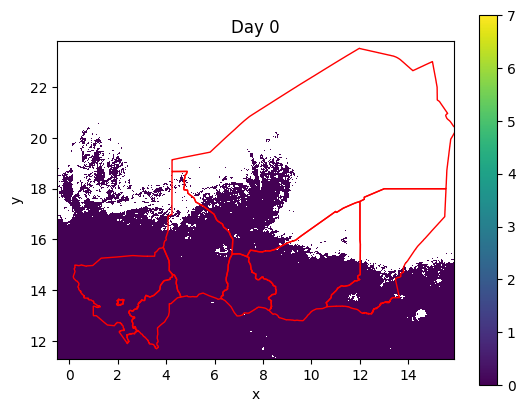

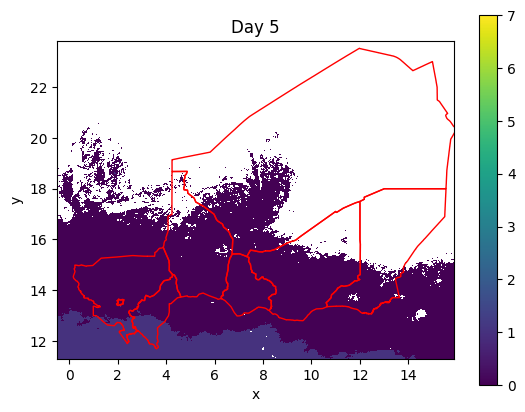

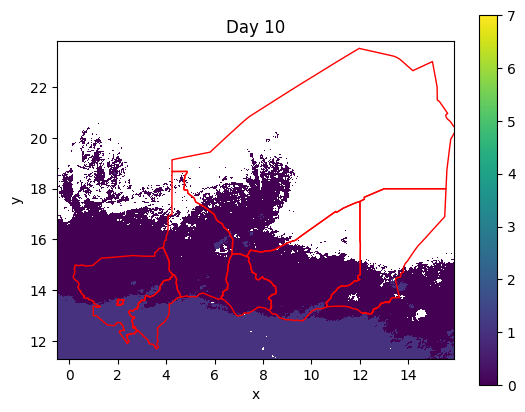

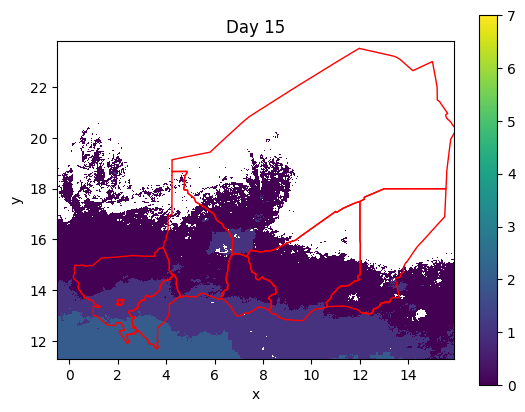

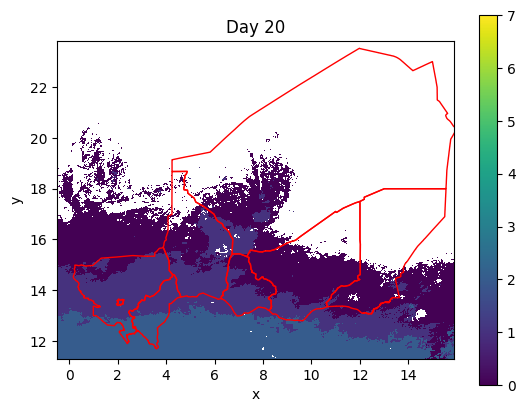

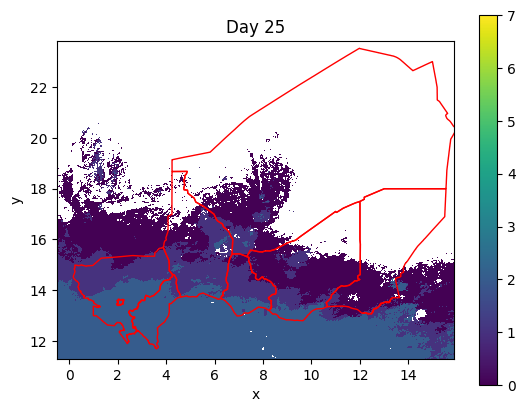

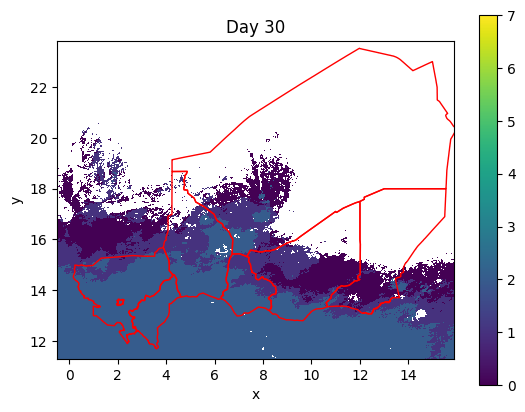

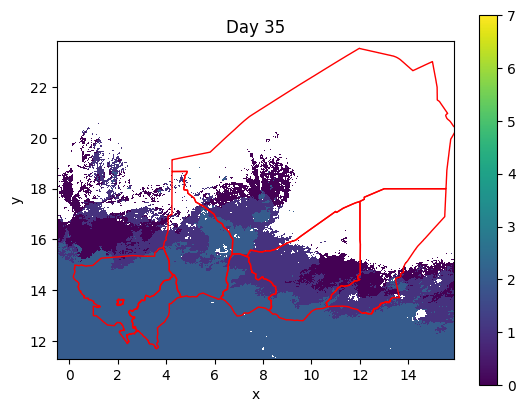

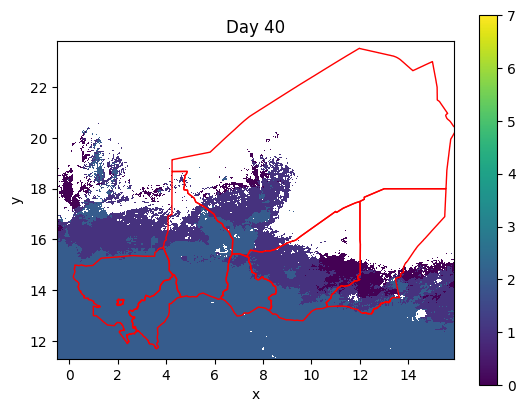

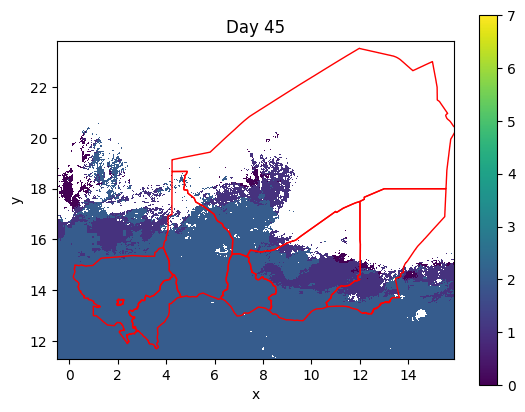

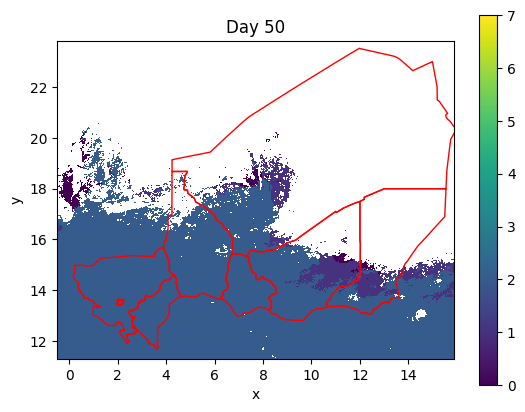

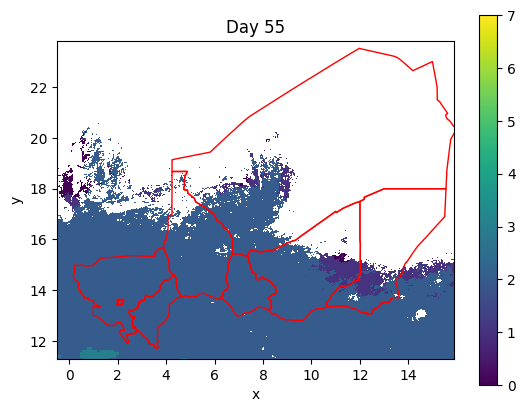

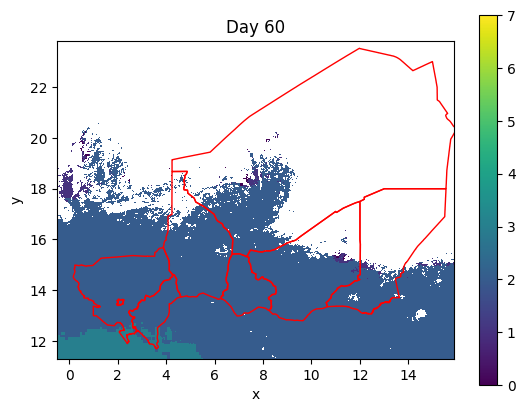

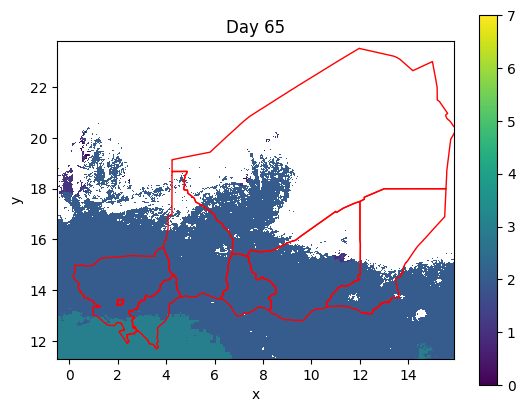

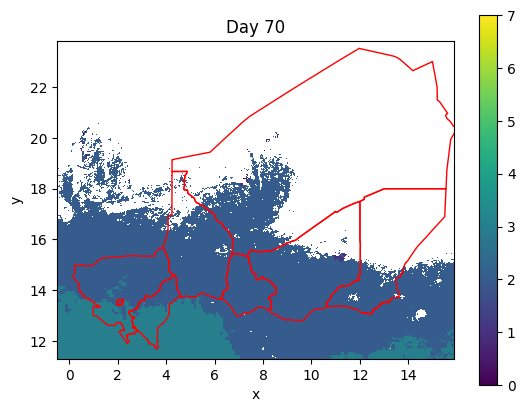

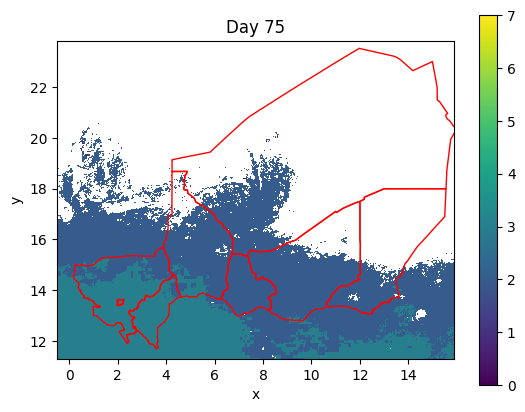

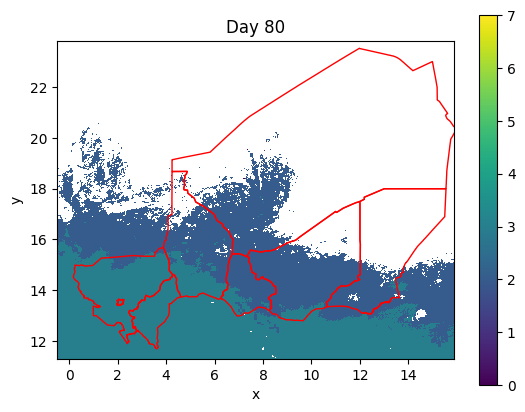

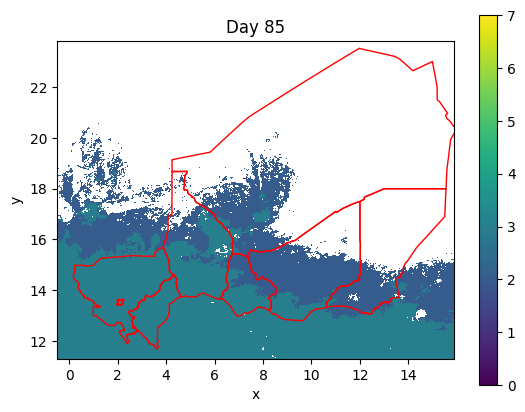

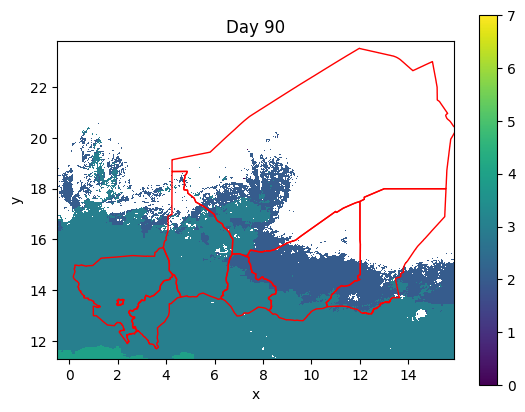

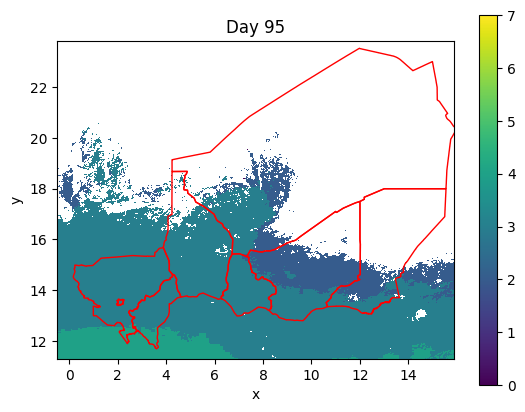

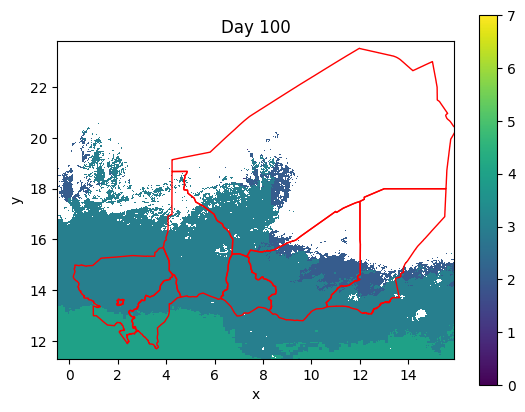

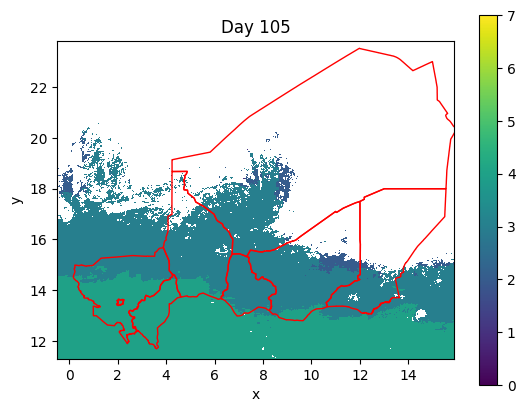

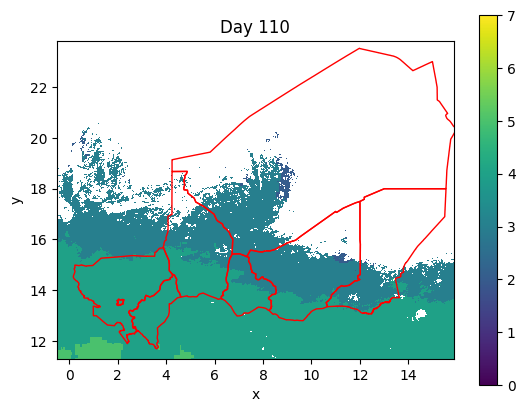

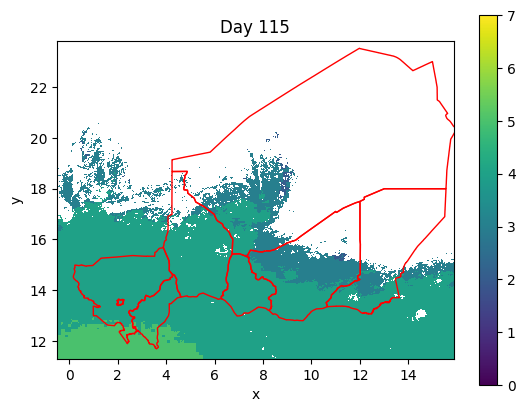

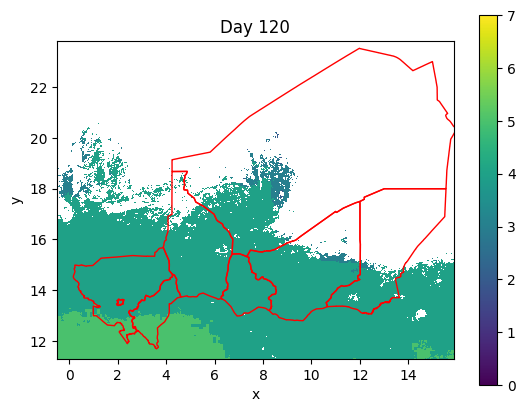

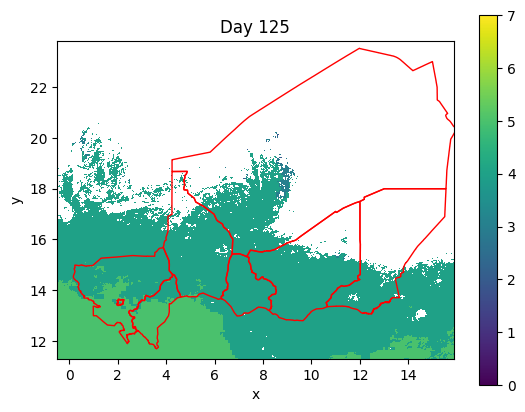

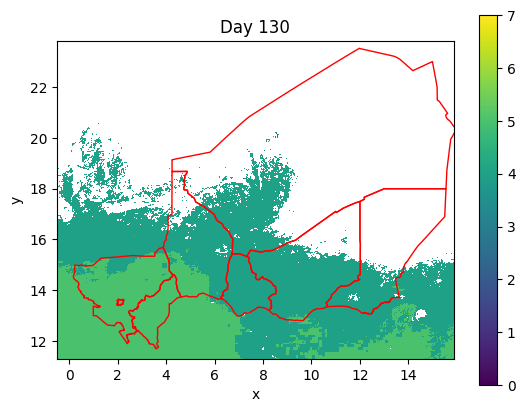

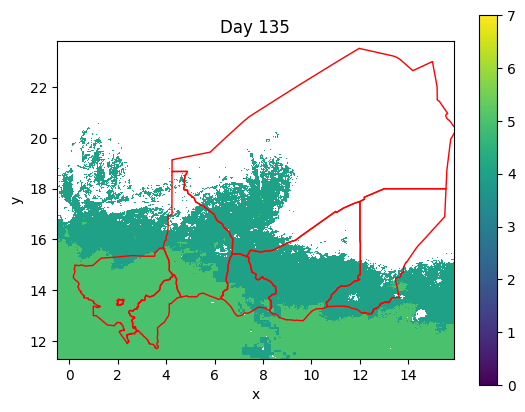

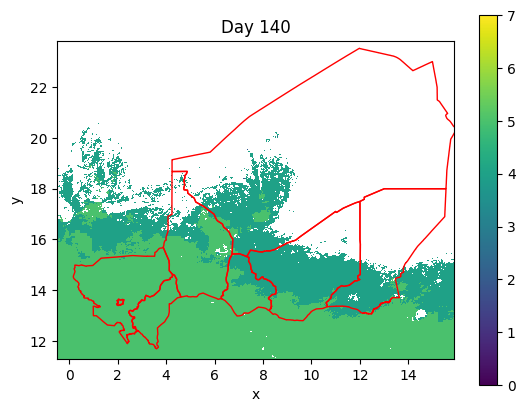

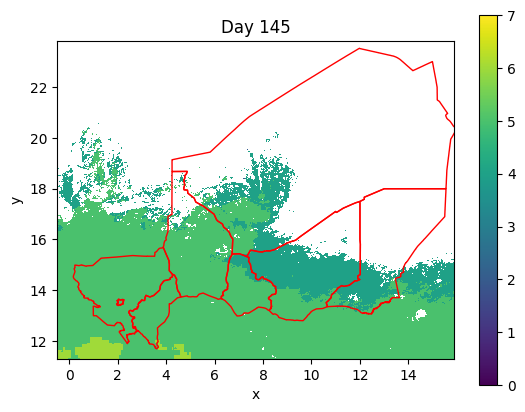

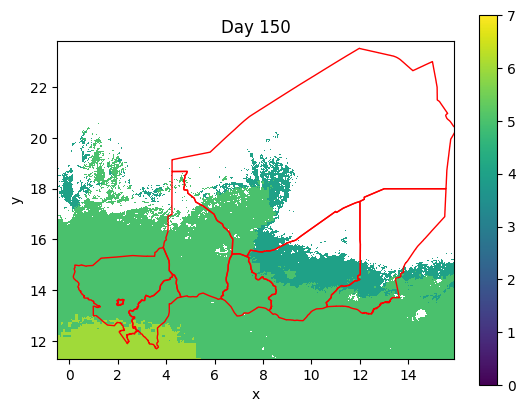

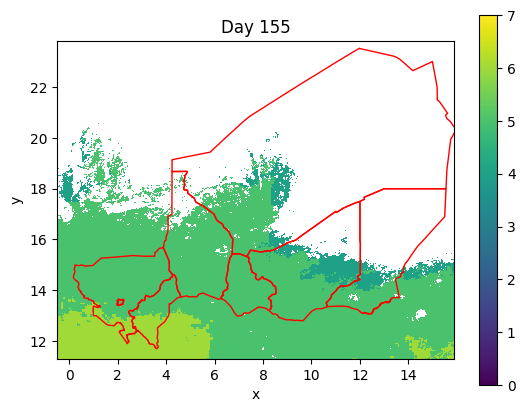

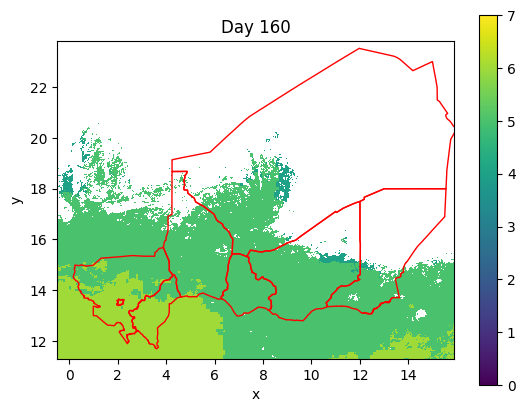

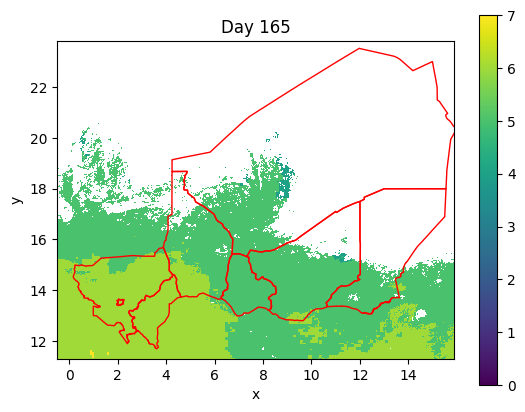

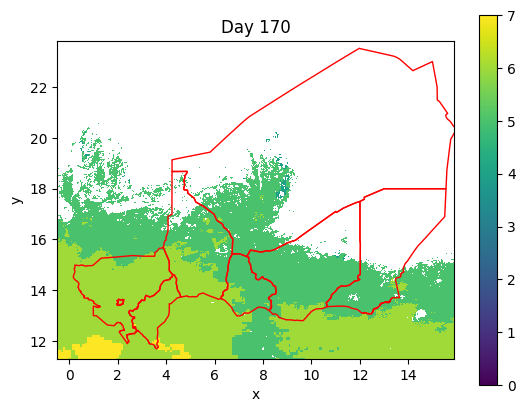

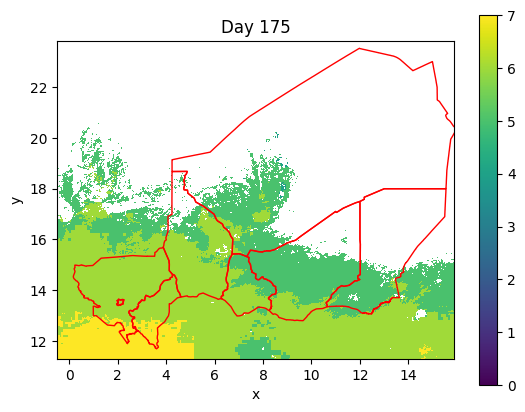

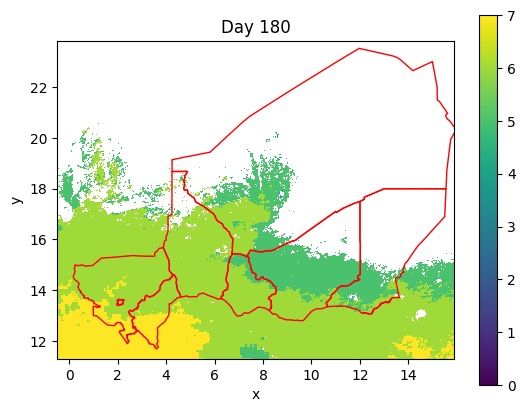

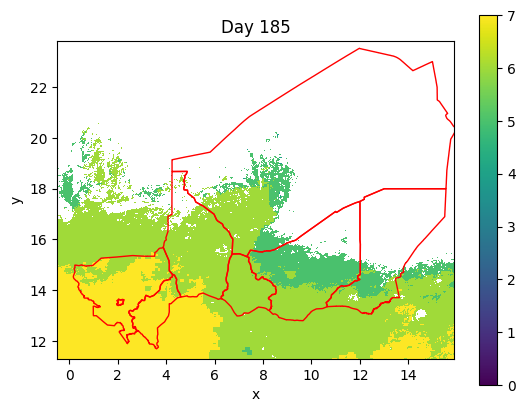

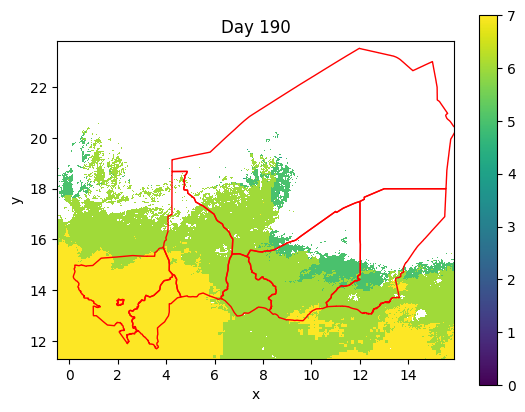

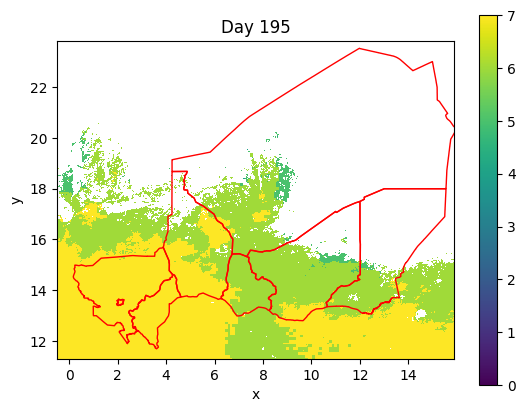

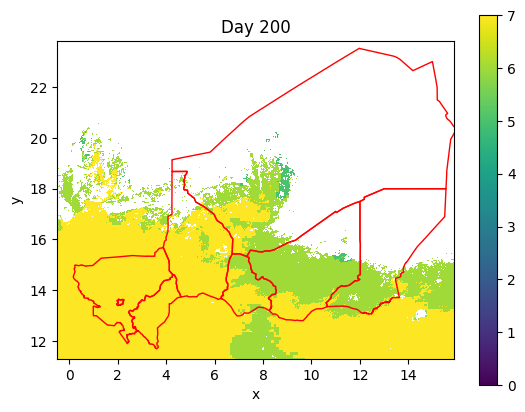

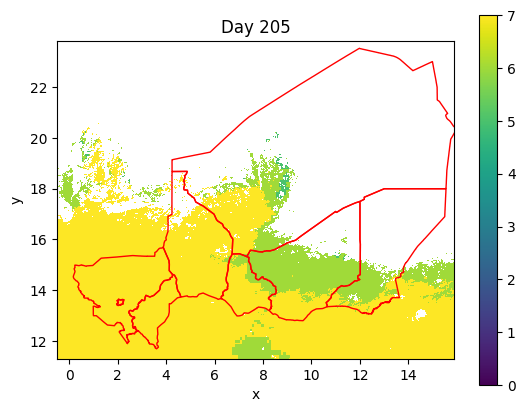

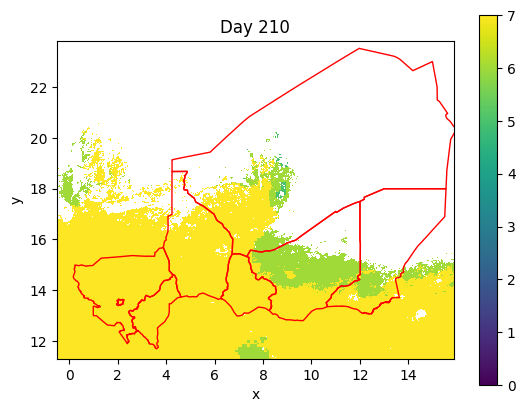

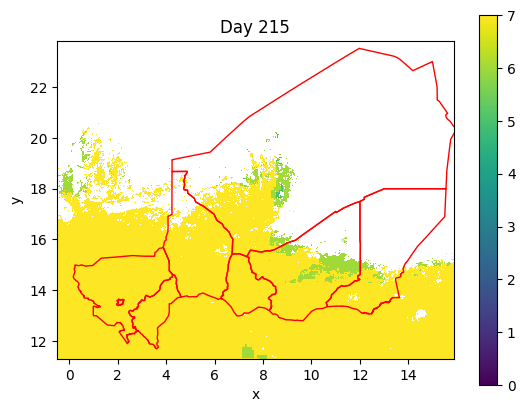

In [16]:
variable = "numPhase" # we define the variable we want to plot, here the number of phenological phase (0 to 7)
time_resolution = 5 # we will make a plot every 5 days
vmax = data[variable].max().values # we define the maximum value for the colorbar
gdf = gpd.read_file("https://fdw.fews.net/files/spatial/geographicunitset/NE_2018.zip") # we load the shapefile of Niger administrative boundaries

# we loop over the time steps and plot the variable
for i in range(int(round(duration/time_resolution, 0))):
    xr.where(np.isnan(data["ru"]),np.nan,data[variable][time_resolution*i,:,:]).plot(vmin=0, vmax=vmax)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

### 5.2 Plotting endpoint simulated yield

/home/lavarenne/my_venv/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'pyogrio_7ede7c75de55435c81cb814c8b43f29a.zip': 'NE_Admin1_2018' (default), 'NE_Admin2_2018', 'NE_Admin3_2018'. Specify layer parameter to avoid this warning.
  result = read_func(


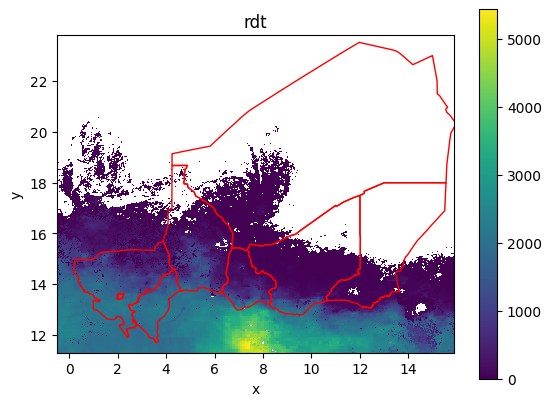

In [15]:
variable = "rdt" # we define the variable we want to plot, here the yield (rendement), in kg/ha
gdf = gpd.read_file("https://fdw.fews.net/files/spatial/geographicunitset/NE_2018.zip") # we load the shapefile of Niger administrative boundaries

# we plot the variable at the last time step
xr.where(np.isnan(data["ru"]),np.nan,data[variable][-1,:,:]).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()